### HVA for Heisenberg Hamiltonian

Final energy per qubit = -1.634967363467498


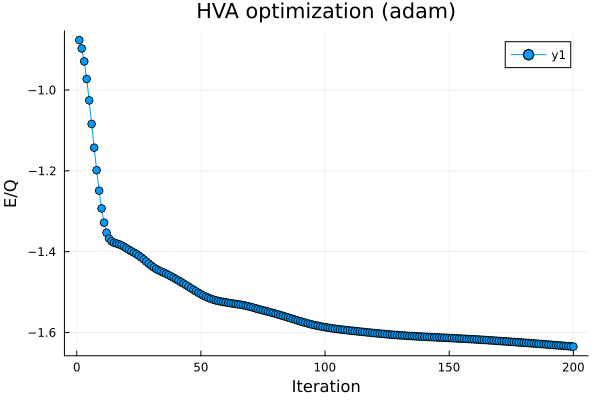

([0.4323502885635008, 0.16864875530591686, 0.15913973791517322, -0.7666395968806856, -0.3932399376306411, 0.8720401330707785, 0.9278816367914359, -0.03284746048871261, -0.08696490958842917, -0.28903350137284206  …  0.38990484630520517, 0.4014875389710202, -0.011597301139999764, 0.04077777344568957, 1.2235422082147716, 0.04398175130895232, 0.10133547479425338, -0.10187701689643537, -0.44077708707847024, 1.5774022298321269], [-0.8762635976511799, -0.8969850543761814, -0.9291009445848761, -0.9725669615928523, -1.025567378107147, -1.083896738310777, -1.1426267478506575, -1.1984222361987784, -1.249041867228796, -1.292893493388045  …  -1.630527606587624, -1.6310183733217472, -1.6315099513095652, -1.6320020147684198, -1.6324944295210968, -1.6329872429555787, -1.6334806475989934, -1.633974927847073, -1.634470401244583, -1.634967363467498])

In [14]:
using PauliPropagation
using ReverseDiff
using ReverseDiff: GradientTape, compile, gradient!
using Distributions: Uniform
using Plots
using NLopt
using Random

# ──────────────────────────────────────────────────────────────
# 1. Heisenberg Hamiltonian (we don't use this, because H is defined again in the loss function)
# ──────────────────────────────────────────────────────────────
function heisenberg_1d_obc(nq::Int; topology=nothing)
    if isnothing(topology)
        topology = bricklayertopology(nq; periodic=false)
    end
    H = PauliSum(nq)
    for pair in topology
        add!(H, [:X, :X], collect(pair), 1.0)
        add!(H, [:Y, :Y], collect(pair), 1.0)
        add!(H, [:Z, :Z], collect(pair), 1.0)
    end
    return H
end

# ──────────────────────────────────────────────────────────────
# 2. Néel state overlap
# ──────────────────────────────────────────────────────────────
function neel_bits(nq::Int; up_on_odd::Bool=true)
    if up_on_odd
        return collect(2:2:nq)
    else
        return collect(1:2:nq)
    end
end

function overlapwithneel(operator, nq::Int; up_on_odd::Bool=true)
    nb = neel_bits(nq; up_on_odd=up_on_odd)
    return overlapwithcomputational(operator, nb)
end

# ──────────────────────────────────────────────────────────────
# 3. HVA circuit construction
# ──────────────────────────────────────────────────────────────

function build_HVA_circ_Heisenberg(nq::Int, p::Int; topology=nothing)
    circuit = Gate[]
    if topology === nothing
        topology = bricklayertopology(nq; periodic=false)
    end
    for _ in 1:p
        rxxlayer!(circuit, topology)
        ryylayer!(circuit, topology)
        rzzlayer!(circuit, topology)
    end
    return circuit
end

# ──────────────────────────────────────────────────────────────
# 4. Loss function for optimization
# ──────────────────────────────────────────────────────────────
function HVA_loss(thetas::AbstractVector, circuit, nq;
    topology=nothing, max_freq=Inf, max_weight=Inf)
    if isnothing(topology)
        topology = bricklayertopology(nq; periodic=false)
    end

    CoeffType = eltype(thetas)
    H = PauliSum(CoeffType, nq)
    for pair in topology
        add!(H, [:X, :X], collect(pair), CoeffType(1.0))
        add!(H, [:Y, :Y], collect(pair), CoeffType(1.0))
        add!(H, [:Z, :Z], collect(pair), CoeffType(1.0))
    end

    wrapped_H = wrapcoefficients(H, PauliFreqTracker)
    propagated = propagate!(circuit, wrapped_H, thetas; max_freq, max_weight) 
    return overlapwithneel(propagated, nq)
end

# ──────────────────────────────────────────────────────────────
# 5. Optimizers: Adam, LBFGS
# ──────────────────────────────────────────────────────────────
function adam_optimizer(thetas_init, lossfun, nq; eta=0.02, steps=150)
    tape = GradientTape(lossfun, thetas_init)
    compile(tape)
    grad = similar(thetas_init)
    thetas = copy(thetas_init)
    opt_energy = Float64[]

    m = zero(thetas)
    v = zero(thetas)
    β1, β2, ϵ = 0.9, 0.999, 1e-8

    for t in 1:steps
        gradient!(grad, tape, thetas)
        m .= β1 .* m .+ (1 - β1) .* grad
        v .= β2 .* v .+ (1 - β2) .* (grad .^ 2)
        m̂ = m ./ (1 - β1^t)
        v̂ = v ./ (1 - β2^t)
        thetas .-= eta .* m̂ ./ (sqrt.(v̂) .+ ϵ)
        push!(opt_energy, lossfun(thetas) / nq)
    end
    return thetas, opt_energy
end

function lbfgs_optimizer(thetas_init, lossfun, nq; max_iters=300)
    n = length(thetas_init)
    tape = GradientTape(lossfun, thetas_init)
    compile(tape)
    gradbuf = zeros(n)
    opt = NLopt.Opt(:LD_LBFGS, n)
    NLopt.maxeval!(opt, max_iters)

    opt_energy = Float64[]
    NLopt.min_objective!(opt, (x, grad) -> begin
        fx = lossfun(x)::Float64
        if !isempty(grad)
            gradient!(gradbuf, tape, x)
            grad .= gradbuf
        end
        push!(opt_energy, fx)
        return fx
    end)
    minf, thetas, ret = NLopt.optimize(opt, thetas_init)
    return thetas, opt_energy ./ nq
end

# ──────────────────────────────────────────────────────────────
# 6. Run HVA optimization
# ──────────────────────────────────────────────────────────────
function run_HVA(nq::Int=3; p::Int=2, opt::Symbol=:adam, verbose=true, max_freq=Inf, max_weight=Inf, steps=150)
    circuit = build_HVA_circ_Heisenberg(nq, p)
    nparams = length(circuit)
    thetas_init = rand(Uniform(-0.1, 0.1), nparams)

    # tie closure for differentiation
    closed_loss = let const_circ = circuit, const_nq = nq, const_max_freq=max_freq, const_max_weight=max_weight
        θ -> HVA_loss(θ, const_circ, const_nq; max_freq=const_max_freq, max_weight=const_max_weight)
    end

    if opt == :adam
        thetas, E = adam_optimizer(thetas_init, closed_loss, nq; steps=steps)
    elseif opt == :lbfgs
        thetas, E = lbfgs_optimizer(thetas_init, closed_loss, nq)
    else
        error("Unknown optimizer $opt")
    end

    if verbose
        println("Final energy per qubit = $(E[end])")
        plot(E, marker=:o, xlabel="Iteration", ylabel="E/Q", title="HVA optimization ($opt)")
        display(current())
    end
    return thetas, E
end

# ──────────────────────────────────────────────────────────────
# 7. Example run
# ──────────────────────────────────────────────────────────────
nq = 7
p = 5
thetas, E = run_HVA(nq; p=p, opt=:adam, verbose=true, max_freq=20, max_weight = 10, steps=200)

Works for odd number of spins, not for even. 

### HVA for TFIM

In [32]:
function HVA_loss_TFIM_obc(thetas::AbstractVector, circuit, nq;
    topology=nothing, max_freq=Inf, max_weight=Inf)
    if isnothing(topology)
        topology = bricklayertopology(nq; periodic=false)
    end

    CoeffType = eltype(thetas)

    H = PauliSum(CoeffType, nq) 
    
    for qind in 1:nq
        add!(H, :X, qind, CoeffType(1.0))
    end
    for pair in topology
        add!(H, [:Z, :Z], collect(pair), CoeffType(1.0))
    end

    wrapped_H = wrapcoefficients(H, PauliFreqTracker)
    propagated = propagate!(circuit, wrapped_H, thetas; max_freq, max_weight) 
    return overlapwithplus(propagated)
end


HVA_loss_TFIM_obc (generic function with 1 method)

In [34]:
function run_HVA_TFIM(nq::Int=3; nl::Int=2, opt::Symbol=:adam, verbose=true, max_freq=Inf, max_weight=Inf, steps=150)
    circuit = tfitrottercircuit(nq, nl)
    nparams = length(circuit)
    thetas_init = rand(Uniform(-0.1,0.1), nparams)

    # tie closure for differentiation
    closed_loss = let const_circ = circuit, const_nq = nq, const_max_freq=max_freq, const_max_weight=max_weight
        θ -> HVA_loss_TFIM_obc(θ, const_circ, const_nq; max_freq=const_max_freq, max_weight=const_max_weight)
    end

    if opt == :adam
        thetas, E = adam_optimizer(thetas_init, closed_loss, nq; steps=steps)
    elseif opt == :lbfgs
        thetas, E = lbfgs_optimizer(thetas_init, closed_loss, nq)
    else
        error("Unknown optimizer $opt")
    end

    if verbose
        println("Final energy per qubit = $(E[end])")
        plot(E, marker=:o, xlabel="Iteration", ylabel="E/Q", title="HVA optimization ($opt)")
        display(current())
    end
    return thetas, E
end


run_HVA_TFIM (generic function with 2 methods)

Final energy per qubit = -1.0680180082756685


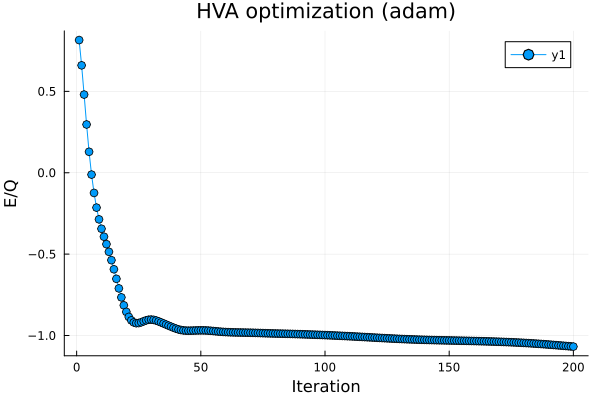

([-0.44593054954900546, -0.2724528301974636, -0.497293577686003, -0.3856562918218926, 0.08118107139699163, -0.21219172049254434, 0.2704791376383598, -0.2133066444153844, -0.00663737661718346, -0.3872736990833314  …  0.8430497874586195, -0.37165211022576106, -0.043529534032126144, -0.31935219162641776, -0.037996835005147916, 0.1597226294481532, -0.05429459790641385, -0.05346446409830276, 0.9802812018632235, 0.44539515192150564], [0.8150119353224115, 0.6598034692667293, 0.48015441138571513, 0.29644157553336914, 0.12864697591697385, -0.011456666024562735, -0.12404177517411168, -0.2142136880035168, -0.28627738467640446, -0.3441518590656743  …  -1.056647165091626, -1.0578723368531013, -1.0591176754636458, -1.060379192758452, -1.0616524770168905, -1.0629327363433378, -1.0642148566538554, -1.065493473739564, -1.066763057850621, -1.0680180082756685])

In [47]:
# test run
nq=5
nl=7
thetas, E = run_HVA_TFIM(nq; nl=nl, opt=:adam, verbose=true, max_freq=Inf, max_weight = Inf, steps=200)

For odd, we end up in first excited state. For even we end up in the ground state.